# Emerging Technologies Project

The following notebook trains a model that can be used to predict power output from wind speed values, as defined in the `powerproduction` dataset.

## Preamble

I'll begin by importing the necessary packages and reading in the dataset.

In [1]:
import tensorflow.keras as kr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Plot style
plt.style.use("ggplot")

# Plot size
plt.rcParams['figure.figsize'] = [14, 8]

In [3]:
# Read in the dataset
df = pd.read_csv("./powerproduction.csv")

# Print the first few rows
df.head(8)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826


Next I'll partition the dataset into a training set and a testing set. The testing set will make up 20% of the total items in the overall dataset.

In [4]:
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

print("Training:")
print(train.head())
print()
print("Testing:")
print(test.head())

Training:
      speed    power
90    4.905    7.060
254  12.713   51.149
283  14.489   71.763
445  22.422   99.357
461  23.273  113.556

Testing:
    speed  power
9   0.526  5.553
25  1.051  2.085
28  1.151  1.208
31  1.301  0.000
32  1.401  4.156


## Linear Model

First I'll construct a linear modal and attempt to make predictions using that. This is done below using Keras' Sequential class, which represents a linear grouping of layers [1]. The model created below contains a single dense layer. A dense layer is a layer in neural network that’s fully connected, meaning all the neurons in one layer are connected to all other neurons in the next layer [1].

In [5]:
# Create a neural network with one neuron
model = kr.models.Sequential()

# Add a single dense layer
model.add(
    kr.layers.Dense(
        1,
        input_shape=(1,),
        activation="linear",
        kernel_initializer='ones',
        bias_initializer='zeros'
    )
)

# Compile the model
model.compile('adam', loss='mean_squared_error')

In [6]:
# Train the neural network on the training data
model.fit(
    train.speed,
    train.power,
    epochs=200,
    batch_size=10
)

Epoch 1/200
40/40 [==============================] - 0s 402us/step - loss: 2518.4791
Epoch 2/200
40/40 [==============================] - 0s 966us/step - loss: 2279.6079
Epoch 3/200
40/40 [==============================] - 0s 803us/step - loss: 2225.6042
Epoch 4/200
40/40 [==============================] - 0s 1ms/step - loss: 2422.7256
Epoch 5/200
40/40 [==============================] - 0s 970us/step - loss: 2299.4730
Epoch 6/200
40/40 [==============================] - 0s 801us/step - loss: 2275.8728
Epoch 7/200
40/40 [==============================] - 0s 802us/step - loss: 2208.6391
Epoch 8/200
40/40 [==============================] - 0s 568us/step - loss: 2115.6134
Epoch 9/200
40/40 [==============================] - 0s 803us/step - loss: 2089.2833
Epoch 10/200
40/40 [==============================] - 0s 403us/step - loss: 1968.8698
Epoch 11/200
40/40 [==============================] - 0s 571us/step - loss: 2177.6697
Epoch 12/200
40/40 [==============================] - 0s 799us/st

40/40 [==============================] - 0s 401us/step - loss: 567.2667
Epoch 97/200
40/40 [==============================] - 0s 568us/step - loss: 549.4404
Epoch 98/200
40/40 [==============================] - 0s 401us/step - loss: 625.2426
Epoch 99/200
40/40 [==============================] - 0s 801us/step - loss: 503.8183
Epoch 100/200
40/40 [==============================] - 0s 401us/step - loss: 581.8543
Epoch 101/200
40/40 [==============================] - 0s 568us/step - loss: 564.2023
Epoch 102/200
40/40 [==============================] - 0s 802us/step - loss: 522.0002
Epoch 103/200
40/40 [==============================] - 0s 801us/step - loss: 483.8629
Epoch 104/200
40/40 [==============================] - 0s 401us/step - loss: 549.1089
Epoch 105/200
40/40 [==============================] - 0s 167us/step - loss: 517.4760
Epoch 106/200
40/40 [==============================] - 0s 401us/step - loss: 530.9100
Epoch 107/200
40/40 [==============================] - 0s 801us/step - 

40/40 [==============================] - 0s 802us/step - loss: 537.4922
Epoch 192/200
40/40 [==============================] - 0s 801us/step - loss: 469.4573
Epoch 193/200
40/40 [==============================] - 0s 401us/step - loss: 655.2285
Epoch 194/200
40/40 [==============================] - 0s 569us/step - loss: 538.8846
Epoch 195/200
40/40 [==============================] - 0s 802us/step - loss: 526.6275
Epoch 196/200
40/40 [==============================] - 0s 401us/step - loss: 606.2536
Epoch 197/200
40/40 [==============================] - 0s 401us/step - loss: 454.5701
Epoch 198/200
40/40 [==============================] - 0s 569us/step - loss: 561.6043
Epoch 199/200
40/40 [==============================] - 0s 401us/step - loss: 616.8274
Epoch 200/200
40/40 [==============================] - 0s 802us/step - loss: 471.5845


### Analysis

Now that the training is completed, the model can be used to make predictions. Firstly, I'll visualise the results by plotting the values of the `train` dataset along with the predicted values of each point in the `test` dataset.

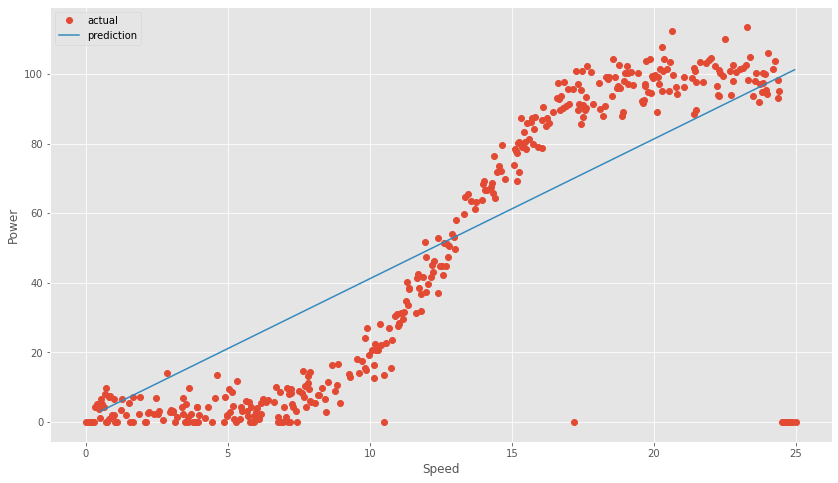

In [7]:
# Plot the training dataset
plt.plot(
    train.speed,
    train.power,
    'o',
    label='actual'
)

# Plot the predictions from the `test` dataset
plt.plot(
    test.speed, 
    model.predict(test.speed),
    label='prediction'
)

plt.xlabel('Speed')
plt.ylabel('Power')

plt.legend();

We can also predict individual values using Keras' `model.predict()` function. Below I find the predicted power value if the speed is 20, and then show where the result appears on the plot.

In [8]:
# Take a hand-picked speed value and view its predicted power value
pred_speed = 20.0
pred_power = model.predict([pred_speed])[0]

pred_power

array([81.318344], dtype=float32)

In [9]:
def plot_predictions():
    # Plot the predictions of the x values we trained on
    plt.plot(
        train.speed,
        train.power,
        'o',
        label='actual'
    )

    plt.plot(
        test.speed, 
        model.predict(test.speed),
        label='prediction'
    )

    plt.xlabel('Speed')
    plt.ylabel('Power')

    # Show the prediction location on the plot
    # Ref: https://www.mathworks.com/matlabcentral/answers/430336-draw-lines-from-both-axis-to-point-in-plot
    plt.plot([pred_speed, pred_speed], [0, pred_power], 'k-')
    plt.plot([0, pred_speed], [pred_power, pred_power], 'k-') 

    plt.legend();

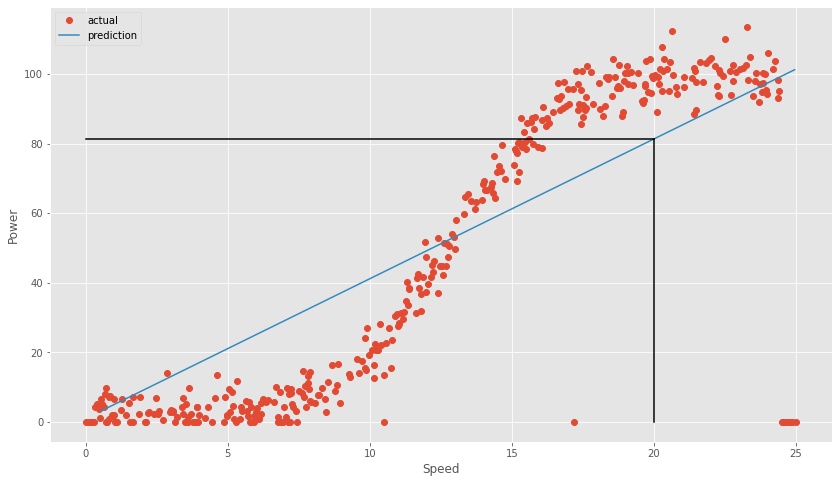

In [10]:
plot_predictions()

As illustrated above, if we attempt to predict the power when the wind speed is 20, we get a value that is much lower than what we would expect. This is because the data in our dataset is not linear, and therefore linear regression is not the best form of regression to perform if we want to make accurate predictions.

## Non-Linear Regression

Linear regression states that the relationship between an independent variable $x$ and a dependent variable $y$ can be best expressed with a line [2]. However, because the `powerproduction` dataset non-linear it would make more sense to do polynomial regression. Polynomial regression expresses the relation between two variables as a polynomial curve [2].

In [11]:
# Re-build the model
model = kr.models.Sequential()

model.add(
    kr.layers.Dense(
        64,
        input_shape=(1,),
        activation='sigmoid',
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform"
    )
)

model.add(
    kr.layers.Dense(
        1,
        activation='linear',
    )
)

model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [12]:
# Fit the data.
model.fit(
    train.speed,
    train.power,
    epochs=300,
    batch_size=10
)

Epoch 1/300
40/40 [==============================] - 0s 802us/step - loss: 3908.3434
Epoch 2/300
40/40 [==============================] - 0s 568us/step - loss: 3592.2363
Epoch 3/300
40/40 [==============================] - 0s 802us/step - loss: 3612.5430
Epoch 4/300
40/40 [==============================] - 0s 801us/step - loss: 3322.1586
Epoch 5/300
40/40 [==============================] - 0s 970us/step - loss: 3039.4879
Epoch 6/300
40/40 [==============================] - 0s 801us/step - loss: 3276.7678
Epoch 7/300
40/40 [==============================] - 0s 1ms/step - loss: 2719.5159
Epoch 8/300
40/40 [==============================] - 0s 804us/step - loss: 2582.7694
Epoch 9/300
40/40 [==============================] - 0s 1ms/step - loss: 2641.3946
Epoch 10/300
40/40 [==============================] - 0s 969us/step - loss: 2500.6018
Epoch 11/300
40/40 [==============================] - 0s 1ms/step - loss: 2278.3364
Epoch 12/300
40/40 [==============================] - 0s 969us/step -

40/40 [==============================] - 0s 801us/step - loss: 315.5356
Epoch 98/300
40/40 [==============================] - 0s 968us/step - loss: 323.6472
Epoch 99/300
40/40 [==============================] - 0s 801us/step - loss: 442.5873
Epoch 100/300
40/40 [==============================] - 0s 802us/step - loss: 356.6837
Epoch 101/300
40/40 [==============================] - 0s 968us/step - loss: 308.6314
Epoch 102/300
40/40 [==============================] - 0s 801us/step - loss: 403.4873
Epoch 103/300
40/40 [==============================] - 0s 801us/step - loss: 342.8899
Epoch 104/300
40/40 [==============================] - 0s 568us/step - loss: 373.6894
Epoch 105/300
40/40 [==============================] - 0s 802us/step - loss: 361.5507
Epoch 106/300
40/40 [==============================] - 0s 401us/step - loss: 360.6091
Epoch 107/300
40/40 [==============================] - 0s 801us/step - loss: 382.6842
Epoch 108/300
40/40 [==============================] - 0s 568us/step -

40/40 [==============================] - 0s 402us/step - loss: 265.4538
Epoch 193/300
40/40 [==============================] - 0s 800us/step - loss: 231.3815
Epoch 194/300
40/40 [==============================] - 0s 801us/step - loss: 291.6680
Epoch 195/300
40/40 [==============================] - 0s 568us/step - loss: 339.5370
Epoch 196/300
40/40 [==============================] - 0s 401us/step - loss: 244.3059
Epoch 197/300
40/40 [==============================] - 0s 401us/step - loss: 352.5225
Epoch 198/300
40/40 [==============================] - 0s 400us/step - loss: 375.6214
Epoch 199/300
40/40 [==============================] - 0s 568us/step - loss: 446.8116
Epoch 200/300
40/40 [==============================] - 0s 400us/step - loss: 342.2387
Epoch 201/300
40/40 [==============================] - 0s 801us/step - loss: 343.2480
Epoch 202/300
40/40 [==============================] - 0s 801us/step - loss: 343.6497
Epoch 203/300
40/40 [==============================] - 0s 568us/step

40/40 [==============================] - 0s 801us/step - loss: 271.9602
Epoch 287/300
40/40 [==============================] - 0s 568us/step - loss: 331.3290
Epoch 288/300
40/40 [==============================] - 0s 401us/step - loss: 235.1033
Epoch 289/300
40/40 [==============================] - 0s 801us/step - loss: 352.4104
Epoch 290/300
40/40 [==============================] - 0s 801us/step - loss: 289.5953
Epoch 291/300
40/40 [==============================] - 0s 568us/step - loss: 270.6670
Epoch 292/300
40/40 [==============================] - 0s 802us/step - loss: 268.7264
Epoch 293/300
40/40 [==============================] - 0s 401us/step - loss: 199.8142
Epoch 294/300
40/40 [==============================] - 0s 400us/step - loss: 311.0626
Epoch 295/300
40/40 [==============================] - 0s 567us/step - loss: 230.7197
Epoch 296/300
40/40 [==============================] - 0s 803us/step - loss: 247.8783
Epoch 297/300
40/40 [==============================] - 0s 800us/step

### Analysis

Once again, we can use this newly created model to make predictions. As done previously, I'll plot the values of the `train` dataset along with the predicted values of each point in the `test` dataset. Doing so, we'll find the predicted values form a curved line.

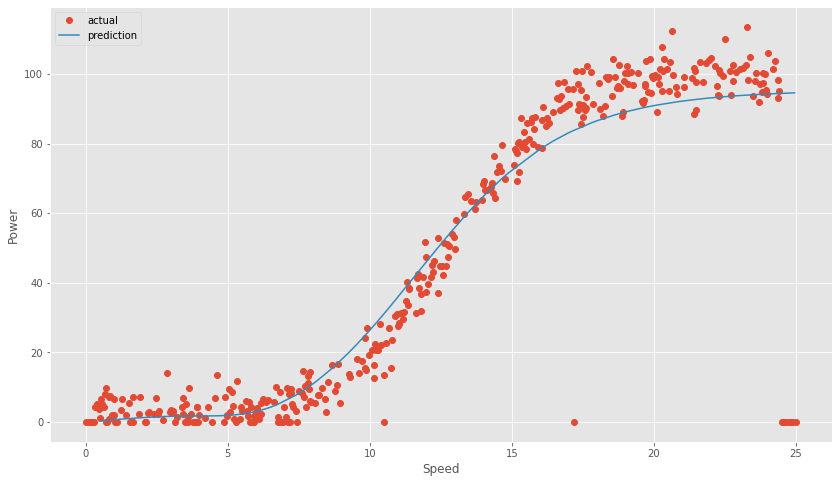

In [13]:
plt.plot(
    train.speed,
    train.power,
    'o',
    label='actual'
)

plt.plot(
    test.speed,
    model.predict(test.speed),
    label='prediction'
)

plt.xlabel('Speed')
plt.ylabel('Power')

plt.legend();

Again, we can provide an input speed of 20 to Keras' `model.predict()` function and plot the result.

In [14]:
pred_power = model.predict([pred_speed])[0]

pred_power

array([90.887665], dtype=float32)

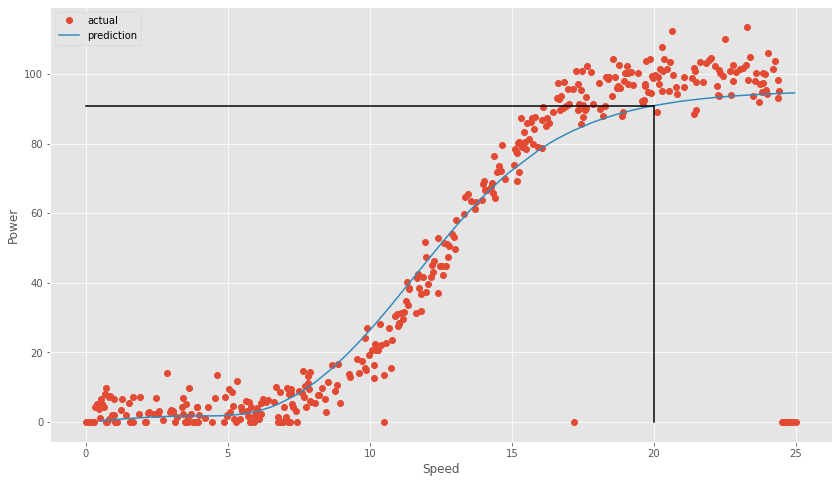

In [15]:
plot_predictions()

We see that the result when using non-linear regression is more accurate compared to the linear model tested previously.

## Saving the Model

We can use `model.save()` to easily save the model for later use in the web application.

In [16]:
model.save('power_prod.h5')

## References

1. [Linear Regression using Keras and Python](https://heartbeat.fritz.ai/linear-regression-using-keras-and-python-7cee2819a60c). Dhiraj K. Heartbeat.
2. [Polynomial Regression using tf.keras](https://medium.com/@anigasan637/polynomial-regression-using-tf-keras-17eaac771256). Ananya Gangavarapu. Medium.